# IGP 5 Models

## Preprocessing

1. import files into dataframe
2. extract 'full' days (1440 rows per date)
3. extract number of days matching scores.csv

In [1]:
# load functions in python file with magic command
%run ../code/preprocess.py

In [2]:
import pandas as pd
folderpath = '../depresjon'
output_csv_path = '../output/'
scores_csv_path = '../depresjon/scores.csv'

# extract files
df = extract_from_folder(folderpath)

# extract full days (true days)
full_df = preprocess_full_days(df)

# extract days per scores 
final = extract_days_per_scores(full_df, scores_csv_path)

# pivot df to wide format
final_pivot = pivot_dataframe(final)

In [3]:
# save to csv
final_pivot.to_csv(output_csv_path + 'preprocessed-wide.csv', index=False)
final.to_csv(output_csv_path+ 'preprocessed-long.csv', index=False)

In [4]:
# list of variable names to delete
var_list = ['df', 'full_df',  'final', 'final_pivot']

# loop over the list and delete variables if they exist
for var in var_list:
    if var in locals():
        del locals()[var]


### Notes

* Kept all id, date combinations to maximise data
* will split into train, test, val
* will keep proportions



## Import from CSV

1. import preprocessed csv file

In [1]:
import pandas as pd
output_csv_path = '../output/'
scores_csv_path = '../depresjon/scores.csv'

# import from csv
df = pd.read_csv(output_csv_path + 'preprocessed-long.csv', parse_dates=['timestamp', 'date'])

## Features



To calculate the features: 

* **Day / Night** - determined by hours, e.g. 08:00-20:00

$\text{{day\_night}} = \begin{cases} 
0 & \text{{if }} \text{{day\_start}} \leq \text{{hour}} < \text{{day\_end}} \\
1 & \text{{otherwise}}
\end{cases}$

* **Light / Dark** - determined by monthly sunset/sunrise times in Norway

$\text{{light\_dark}} = \begin{cases} 
0 & \text{{if }} \text{{sunrise\_time}} \leq \text{{timestamp}} < \text{{sunset\_time}} \\
1 & \text{{otherwise}}
\end{cases}$


* **Active / Inactive** - active is where the rolling average (window = 11) of 'active minute' (`activity threshold` > 5) is greater than `rolling threshold` (2)

$\text{{active\_inactive}} = \begin{cases} 
1 & \text{{if }} \text{{activity}} \geq \text{{activity\_threshold}} \\
0 & \text{{otherwise}}
\end{cases}$

$\text{{rolling\_sum}} = \text{{rolling sum of }} \text{{active\_inactive}} \text{{ over a window of }} \text{{rolling\_window}}$

$\text{{active\_inactive\_period}} = \begin{cases} 
1 & \text{{if }} \text{{rolling\_sum}} \geq \text{{rolling\_threshold}} \\
0 & \text{{otherwise}}
\end{cases}$



>all row level, therfore no data leakage - that is features are computed separately for each (id, date) combination so that there is no data leakage / contamination


* **inactiveDay**: The proportion of time during the day when the participant is inactive.

$\text{{inactiveDay}} = \frac{{\text{{Number of inactive hours during the day}}}}{{\text{{Total number of hours during the day}}}}$


* **activeNight**: The proportion of time during the night when the participant is active.

$\text{{activeNight}} = \frac{{\text{{Number of active hours during the night}}}}{{\text{{Total number of hours during the night}}}}$

* **inactiveLight**: The proportion of time during periods of light (e.g., daytime) when the participant is inactive.

$\text{{inactiveLight}} = \frac{{\text{{Number of inactive hours during periods of light}}}}{{\text{{Total number of hours during periods of light}}}}
$


* **activeDark**: The proportion of time during periods of darkness (e.g., nighttime) when the participant is active.

$\text{{activeDark}} = \frac{{\text{{Number of active hours during periods of darkness}}}}{{\text{{Total number of hours during periods of darkness}}}}$


* **mean**: The average value of activity data for each hour of the day. It represents the central tendency of the data.

$\text{{mean}}_{\text{{person-date}}} = \frac{{\sum_{i=1}^{n} \text{{activity}}_{\text{{person-date}}}(i)}}{{n}}$


* **std**: The standard deviation of activity data for each hour of the day. It measures the dispersion or spread of the data around the mean.

$\text{{std}}_{\text{{person-date}}} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\text{{activity}}_{\text{{person-date}}}(i) - \text{{mean}}_{\text{{person-date}}})^2}$


* **percentZero**: The percentage of data points that have a value of zero for each hour of the day.

$\text{{percent\_zero}}_{\text{{person-date}}} = \frac{{\text{{Number of hours with zero activity}}_{\text{{person-date}}}}}{{\text{{Total number of hours}}_{\text{{person-date}}}}} \times 100$


* **kurtosis**: A measure of the "tailedness" or shape of a distribution. It indicates how sharply peaked or flat the distribution is compared to a normal distribution. Positive kurtosis indicates a relatively peaked distribution, while negative kurtosis indicates a relatively flat distribution.

$\text{{kurtosis}}_{\text{{person-date}}} = \frac{{\frac{1}{n} \sum_{i=1}^{n} (\text{{activity}}_{\text{{person-date}}}(i) - \text{{mean}}_{\text{{person-date}}})^4}}{{\left( \frac{1}{n} \sum_{i=1}^{n} (\text{{activity}}_{\text{{person-date}}}(i) - \text{{mean}}_{\text{{person-date}}})^2 \right)^2}}$

* **median**: The middle value in the sorted list of values.

$\text{median}_{\text{person-date}} = 
\begin{cases} 
\text{activity}_{\text{person-date}}\left(\frac{n+1}{2}\right) & \text{if } n \text{ is odd} \\
\frac{1}{2} \left( \text{activity}_{\text{person-date}}\left(\frac{n}{2}\right) + \text{activity}_{\text{person-date}}\left(\frac{n}{2} + 1\right) \right) & \text{if } n \text{ is even}
\end{cases}$

* **first quartile (0.25)**: The value below which 25% of values fall.

$\text{{Q1}}_{\text{{person-date}}} = \text{{activity}}_{\text{{person-date}}}\left(\frac{n+1}{4}\right)$

* **third quartile (0.75)**: The value below which 75% of values fall.

$\text{{Q3}}_{\text{{person-date}}} = \text{{activity}}_{\text{{person-date}}}\left(\frac{3(n+1)}{4}\right)$


In [3]:
import pandas as pd
output_csv_path = '../output/'
scores_csv_path = '../depresjon/scores.csv'

# load functions in python file with magic command
%run ../code/features.py

In [4]:
# calculate features
features_full = calculate_all_features(df, sunlight_df)

In [5]:
features_full
# save to csv
features_full.to_csv(output_csv_path + 'features.csv', index=False)

## Split into Female, Male, Both datasets

In [6]:
# load functions in python file with magic command
%run ../code/model.py

# import from csv
features_full = pd.read_csv(output_csv_path + 'features.csv', parse_dates=['date'])

In [ ]:
features_full

In [7]:
male, female, both = split_and_prepare_data(features_full)

# shapes of the datasets 
print(f"Male dataset shape: {male.shape}")
print(f"Female dataset shape: {female.shape}")
print(f"Both genders dataset shape: {both.shape}")

# save to csv
male.to_csv(output_csv_path + 'male.csv', index=False)
female.to_csv(output_csv_path + 'female.csv', index=False)
both.to_csv(output_csv_path + 'both.csv', index=False)


Male dataset shape: (310, 12)
Female dataset shape: (383, 12)
Both genders dataset shape: (693, 12)


## Model


In [5]:
# load functions in python file with magic command
%run ../code/model.py

# import from csv
features_full = pd.read_csv(output_csv_path + 'features.csv', parse_dates=['date'])
male = pd.read_csv(output_csv_path + 'male.csv')
female = pd.read_csv(output_csv_path + 'female.csv')
both = pd.read_csv(output_csv_path + 'both.csv')


**Baseline Models**

* Logistic Regression
* Decision Tree
* Random Forest
* Gradient Boosting
* SVM linear
* SVM rbf
* SVC linear
* Naive Bayes
* KNN
* Neural Network
* XGBoost
* LightGBM
* AdaBooast
* QDA



![](../_images/process2-2024-04-26-200144.png)


#### Metrics

* metric selection and reason
  * `accuracy` - prop of correct predictions; good overall performanced indicator
  * `recall (sensitivity)` - prop of actual positives that are correctly identified.  ability to identify all actual cases of depression.  crucial to minimise false negatives that is failing to identify individuals who are depressed.
  * `precision` - prop of predicted depression which are correct (true positive predictions among all positive predictions) - important when need to avoid false positives (unnecessary concern, intervention, medication, treatment)
   * `F1` - harmonic mean of precision and recall - balance between the two, especially if imbalanced class distribution
   * `specificity` - ability to identify non-depression correctly - important to ensure healthy individuals are not misclassified -  measures the proportion of actual negatives that are correctly identified by the mode
  * `MCC` - takes into account true adn false positives and negatives.  reliable statistic rate that produces a high score only if the prediction obtained good results in all four matrix categories
  * `ROC-AUC - Area Under the Receiver Operating Characteristic Curve`: Evaluates the model’s ability to discriminate between the classes. A higher AUC indicates better model performance.   ROC-AUC is suitable for depression prediction when you want to evaluate the model's ability to distinguish between depressed and non-depressed individuals across different threshold settings.
  * `training time`

Considering `accuracy`, `F1`, `MCC`

### Male dataset

In [11]:
# training and validation sets
X_train, X_validation, y_train, y_validation = validation_data(male)
# save to csv
X_train.to_csv(output_csv_path + 'male_X_train.csv', index=False)
X_validation.to_csv(output_csv_path + 'male_X_validation.csv', index=False)
y_train.to_csv(output_csv_path + 'male_y_train.csv', index=False)
y_validation.to_csv(output_csv_path + 'male_y_validation.csv', index=False)


# evaluate models
results = evaluate_models(models1, X_train, y_train)

In [12]:
print_top_models(results, metric='accuracy', top_n=5)
#print_top_models(results, top_n=3)
print_top_models(results, metric='mcc', top_n=5)
print_top_models(results, metric='f1', top_n=5)
print_top_models(results, metric='training_time', top_n=5)

Top 5 models for accuracy:
1. QDA: 0.8931059506531206
2. XGBoost: 0.870464441219158
3. LightGBM: 0.8701015965166908
4. SVC linear: 0.8630624092888244
5. Gradient Boosting: 0.8513062409288825

Top 5 models for mcc:
1. QDA: 0.8007958957751548
2. XGBoost: 0.7481466922835964
3. LightGBM: 0.7430272605945338
4. SVC linear: 0.7301102675113829
5. Gradient Boosting: 0.7074043741336317

Top 5 models for f1:
1. QDA: 0.9082051124304039
2. LightGBM: 0.8798205433208686
3. XGBoost: 0.8788753214303394
4. SVC linear: 0.867569341326147
5. Gradient Boosting: 0.8615595575940954

Top 5 models for training time (fastest to slowest):
1. Naive Bayes: 0.019817256927490236 seconds
2. Decision Tree: 0.028321027755737305 seconds
3. SVM rbf: 0.031135034561157227 seconds
4. SVC linear: 0.032175207138061525 seconds
5. QDA: 0.033115386962890625 seconds



#### Model for `male` - Evaluation

`QDA`, `LightGBM`, `XGBoost`, `GradientBoosting` and `SVC linear` are top five models going to next round - feature evaluation.

### Female Dataset

In [7]:
# training and validation sets
X_train, X_validation, y_train, y_validation = validation_data(female)
# save to csv
X_train.to_csv(output_csv_path + 'female_X_train.csv', index=False)
X_validation.to_csv(output_csv_path + 'female_X_validation.csv', index=False)
y_train.to_csv(output_csv_path + 'female_y_train.csv', index=False)
y_validation.to_csv(output_csv_path + 'female_y_validation.csv', index=False)


# evaluate models
results = evaluate_models(models1, X_train, y_train)

In [10]:
print_top_models(results, metric='accuracy', top_n=5)
#print_top_models(results, top_n=3)
print_top_models(results, metric='mcc', top_n=5)
print_top_models(results, metric='f1', top_n=5)
print_top_models(results, metric='training_time', top_n=5)

Top 5 models for accuracy:
1. Gradient Boosting: 0.8615384615384615
2. XGBoost: 0.8492307692307692
3. Random Forest: 0.8461538461538461
4. LightGBM: 0.8430769230769231
5. SVC linear: 0.8215384615384617

Top 5 models for mcc:
1. Gradient Boosting: 0.6892419168734666
2. Random Forest: 0.6591006072445007
3. XGBoost: 0.6587325419588995
4. LightGBM: 0.6481671625513965
5. SVC linear: 0.5975325105419247

Top 5 models for f1:
1. Gradient Boosting: 0.7881821701333896
2. XGBoost: 0.7656319290465632
3. LightGBM: 0.7646511627906977
4. Random Forest: 0.7626896912611197
5. SVC linear: 0.7250186669698865

Top 5 models for training time (fastest to slowest):
1. Naive Bayes: 0.018730878829956055 seconds
2. QDA: 0.01979990005493164 seconds
3. SVC linear: 0.027005624771118165 seconds
4. Decision Tree: 0.029814386367797853 seconds
5. SVM rbf: 0.0305145263671875 seconds



#### Model for `female` - Evaluation

`Random Forest`, `LightGBM`, `XGBoost`, `GradientBoosting` and `SVC linear` are top five models going to next round.

### Both Dataset

In [11]:
# training and validation sets
X_train, X_validation, y_train, y_validation = validation_data(both)
# save to csv
X_train.to_csv(output_csv_path + 'both_X_train.csv', index=False)
X_validation.to_csv(output_csv_path + 'both_X_validation.csv', index=False)
y_train.to_csv(output_csv_path + 'both_y_train.csv', index=False)
y_validation.to_csv(output_csv_path + 'both_y_validation.csv', index=False)


# evaluate models
results = evaluate_models(models1, X_train, y_train)

In [12]:
print_top_models(results, metric='accuracy', top_n=5)
#print_top_models(results, top_n=3)
print_top_models(results, metric='mcc', top_n=5)
print_top_models(results, metric='f1', top_n=5)
print_top_models(results, metric='training_time', top_n=5)

Top 5 models for accuracy:
1. LightGBM: 0.8794726930320149
2. Gradient Boosting: 0.8743879472693031
3. XGBoost: 0.8743734608141388
4. AdaBoost: 0.8608286252354048
5. Random Forest: 0.8556714471968709

Top 5 models for mcc:
1. LightGBM: 0.7526492396967461
2. XGBoost: 0.7435034299792754
3. Gradient Boosting: 0.7431714155727721
4. AdaBoost: 0.719468311141312
5. Random Forest: 0.7089513642475694

Top 5 models for f1:
1. LightGBM: 0.85027129282787
2. XGBoost: 0.8464070900311895
3. Gradient Boosting: 0.8422523999154068
4. QDA: 0.8229789501951739
5. Random Forest: 0.82262090787392

Top 5 models for training time (fastest to slowest):
1. QDA: 0.01829977035522461 seconds
2. Naive Bayes: 0.018965625762939455 seconds
3. KNN: 0.03705229759216309 seconds
4. Decision Tree: 0.03759641647338867 seconds
5. SVC linear: 0.04386053085327148 seconds



#### Model for `both` - Evaluation

`Random Forest`, `LightGBM`, `XGBoost`, `GradientBoosting` and `AdaBoost` are top five models going to next round.

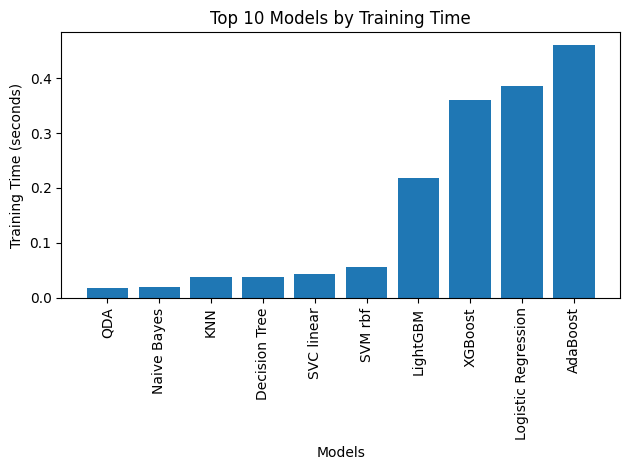

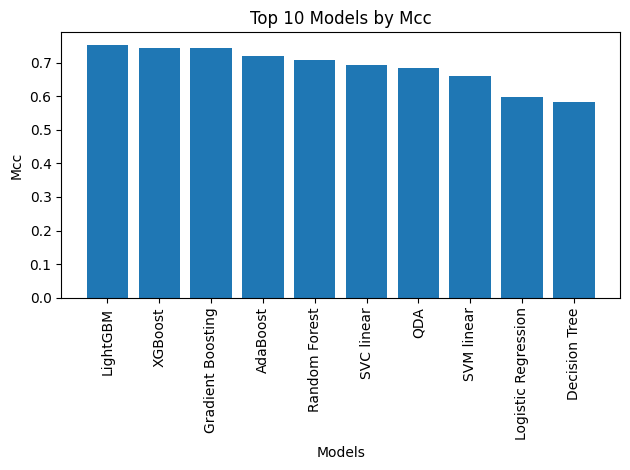

In [31]:
# plot metrics
plot_top_models(results, metric='training_time', top_n=10)
plot_top_models(results, metric='mcc', top_n=10)



BREAK HERE - below is Male Model 2- features

#### Evaluation #1

`QDA`, `LightGBM`, `XGBoost`, `GradientBoosting` and `SVC linear` are top five models going to next round.

Using `SHAP` (SHapley Additive exPlanations):
* cooperative game theory which calculates contribution of each feature to the prediction
* can be used on any model
* positive values mean feature contributes to increasing the prediction; negative value decreases predition

Using `VIF` (Variance Inflation Factor):
* measure to quantify severity of multicollinearity -highly correlated features which lead to unreliable estimates of regression coefficient
* high VIF (greater than 5, 10) suggest that multicollinearity may be an issue - redundant feature or highly correlated


In [ ]:
#!pip install uv shap

In [76]:
models_male = [
    ('Gradient Boosting', GradientBoostingClassifier(random_state=RANDOM_STATE)),
    ('SVC linear', LinearSVC(dual=False, max_iter=10000, random_state=RANDOM_STATE)),
    ('XGBoost', XGBClassifier(random_state=RANDOM_STATE)),
    ('LightGBM', LGBMClassifier(verbose=-1, random_state=RANDOM_STATE)),
    ('QDA', QuadraticDiscriminantAnalysis())
]

In [77]:
# fit each model
for model_name, model in models_male:
    model.fit(X_train, y_train)

In [55]:
male_vif = calculate_vif(X_train)
print(male_vif.sort_values(by='VIF', ascending=False))

                       VIF
mean           2355.738968
std             660.620438
q3              376.903434
activeNight      56.697424
activeDark       46.564577
median           44.982132
inactiveDay      33.238402
inactiveLight    30.598657
percent_zero     12.648110
kurtosis          2.511157
q1                2.458344


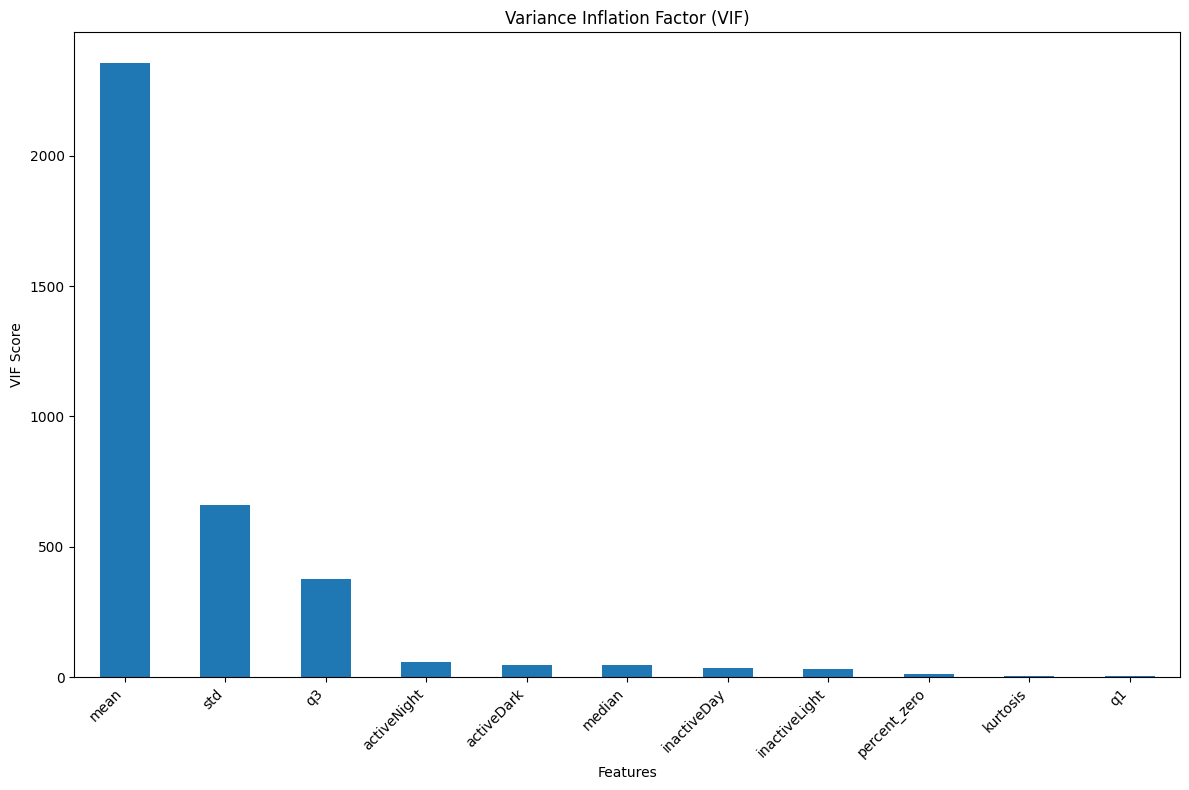

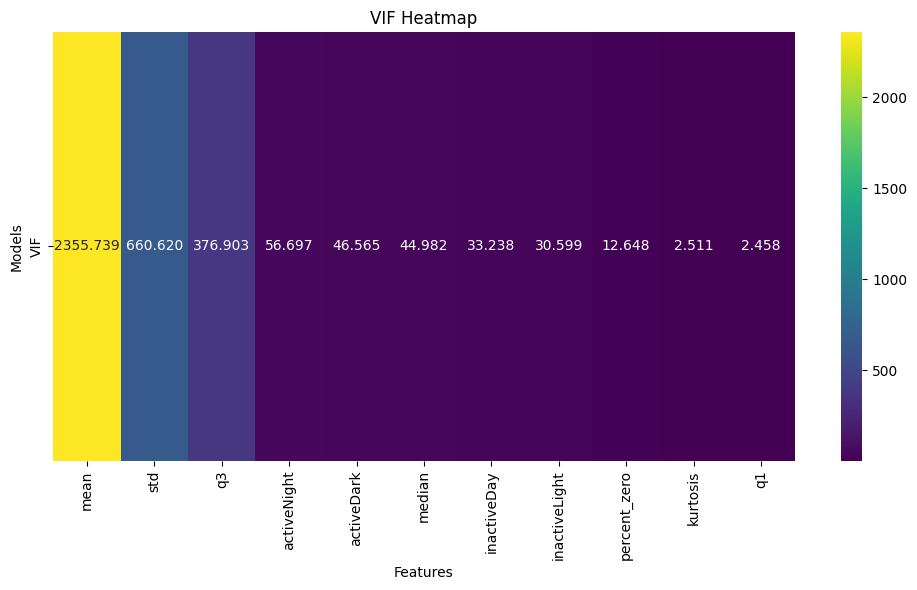

In [58]:
# bar plot vif
plot_vif(male_vif)

# heatmap vif
plot_vif_heatmap(male_vif)

In [87]:
# shap values for male model
male_shap = calculate_shap_feature_importance(models_male, X_train, shap_sampling='auto')

Using 263 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/263 [00:00<?, ?it/s]

Using 263 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/263 [00:00<?, ?it/s]

c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is no

  0%|          | 0/263 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

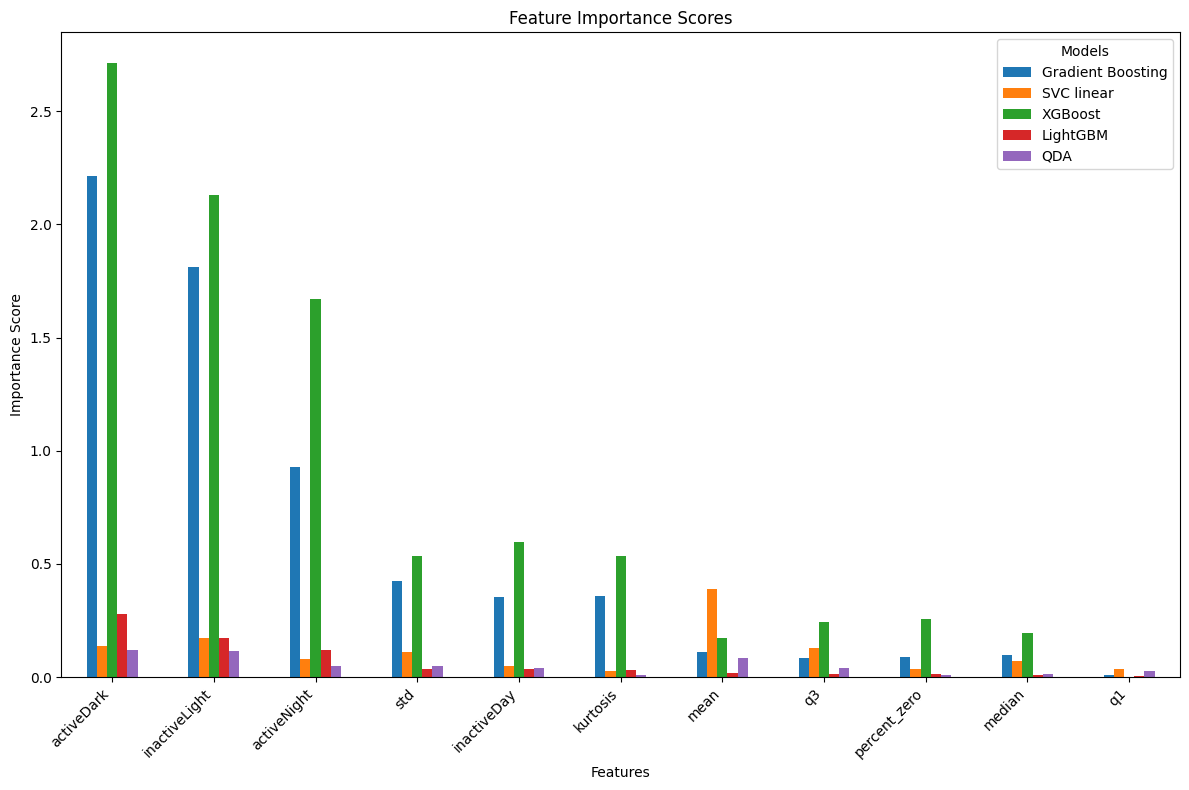

In [89]:
# plot feature importance for each model
plot_feature_importance(male_shap)

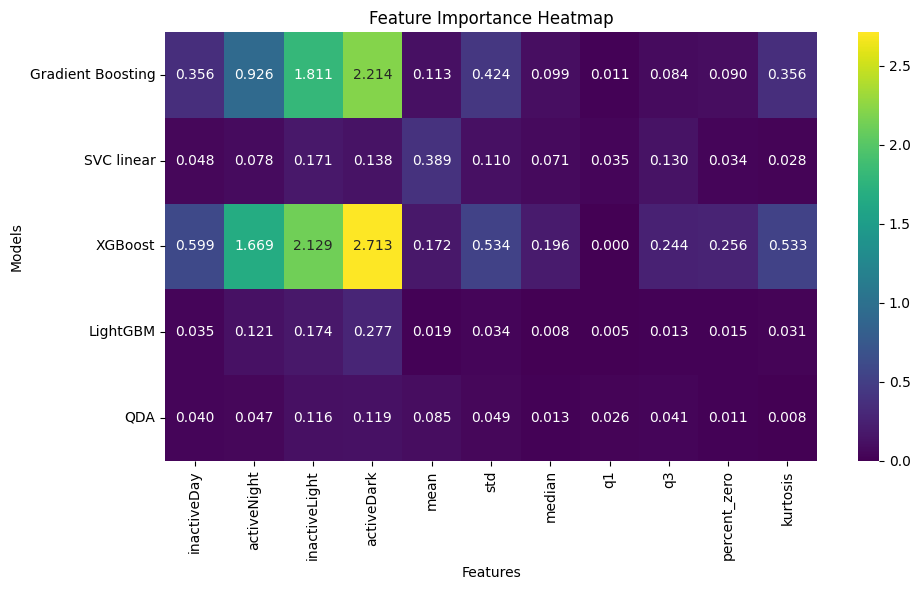

In [90]:
# Sshap heatmap
plot_feature_importance_heatmap(male_shap)

#### Interpretation

**VIF**

* as expected high multicollinearity - most features are highly correlated
* `mean` and `q3` are likely redundant given the distribution
* `activeNight` and `activeDark` are going to be very similar
* `inactiveDay` and `inactiveLight` are going to be very similar

Initial proposal: 
* drop `mean`, `activeDark`, `inactiveLight`
  * rationale is that dark and light features require more calculation than the simpler time-based night/day

**SHAP**

* Tree based explainer favoured `activeDark`, `inactiveLight` and `activeNight`

**Correlation Matrix**

* inactiveLight / inactiveDay
* activeDark / activeNight
* mean / q3
* mean / median
* q3 / std
* q3 / median

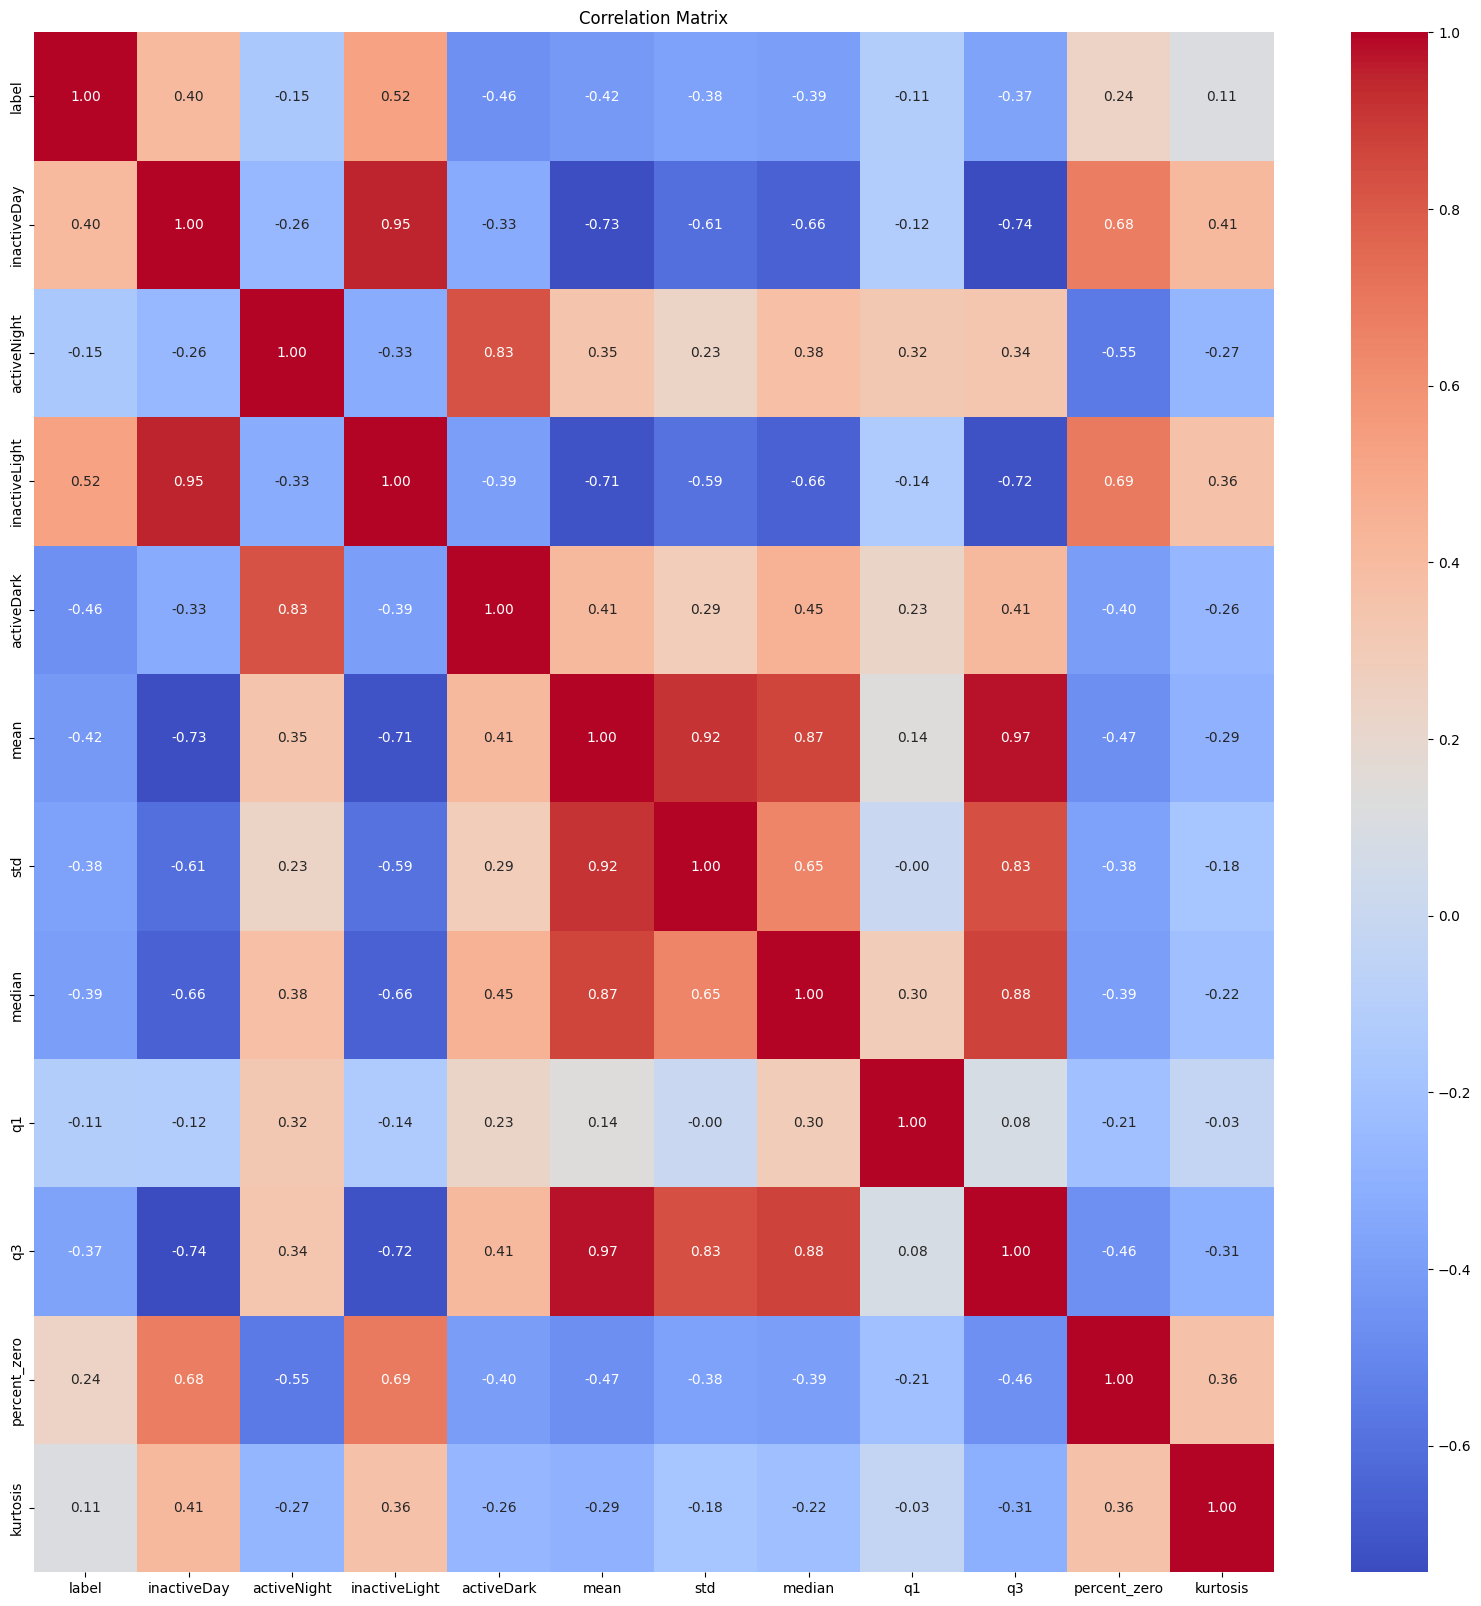

In [93]:
# plot correlation matrix

correlation_matrix = male.corr(method='pearson')
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [130]:
from sklearn.metrics import mean_squared_error
from sklearn.inspection import partial_dependence
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt

model = GradientBoostingRegressor().fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)

# Calculate the mean squared error of the training predictions
mse_train = mean_squared_error(y_train, y_train_pred)

print(f'Training MSE: {mse_train}')


Training MSE: 0.007202697982775841


#### Decision

Because the goal is a simple model which is interpretable, I am opting for dropping features instead of `Principal Component Analysis` - which is dimensionality reduction but keeping features.

### Feature removal modelling

In [142]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Assuming X_train is your feature set and y_train is the target variable
models = {
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVC linear': SVC(kernel='linear'),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'QDA': QuadraticDiscriminantAnalysis()
}

# Dictionary to store results
results = {}

# Filter method
selector = SelectKBest(f_classif, k=5)
X_train_filtered = selector.fit_transform(X_train, y_train)
for name, model in models.items():
    model.fit(X_train_filtered, y_train)
    score = accuracy_score(y_test, model.predict(X_test_filtered))
    results[f'{name}_filter'] = score

# Wrapper method
for name, model in models.items():
    rfe = RFE(model, n_features_to_select=5)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    model.fit(X_train_rfe, y_train)
    score = accuracy_score(y_test, model.predict(X_test_rfe))
    results[f'{name}_wrapper'] = score

# Embedded method
for name, model in models.items():
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    # Select features based on importances...
    # Train model with selected features and store results...

# Print or save the results for interpretation
print(results)


ImportError: cannot import name 'r_regression' from 'sklearn.feature_selection._univariate_selection' (c:\Users\zoona\Anaconda3\envs\igp5_env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py)

* model selection and evaluation strategy
  * either start with many models (garcia) - no hyperparameter
  * choose best mcc, f1, accuracy -> top 3 to go into next round
  * then look at feature importance -> rationale
  * then look at hyperparameter tuning final model
  * then look at ensemble??
  * repeat for other datasets
 
* model evaluation


TODO research Matthews Correlation Coefficient, F1 as key metrics - getting the balance right
TODO add metric maths to slides and their importance (contextual)



* feature importance analysis - SHAP, Feature Permutation
* Hyperparameter tuning
* Ensemble models
* Validation

Flexible Decision Boundary: Unlike linear classifiers like Logistic Regression or Linear Discriminant Analysis (LDA), QDA can model non-linear decision boundaries between classes. This flexibility allows QDA to capture more complex relationships in the data.
Unrestricted Covariance Matrices: QDA allows each class to have its own covariance matrix, whereas Linear Discriminant Analysis (LDA) assumes a common covariance matrix for all classes. This can be beneficial when the classes have different variances or when the relationship between features and classes is complex.
Handling Non-Normal Data: Although QDA assumes that the data within each class follows a multivariate normal distribution, it can still perform well even if this assumption is not strictly met, especially if the departure from normality is not severe.
Effective with Small Datasets: QDA can be effective with small datasets because it estimates separate covariance matrices for each class, potentially providing better modeling of the underlying data distribution.
Robustness to Outliers: QDA can be more robust to outliers compared to linear classifiers like Logistic Regression because it models each class's covariance separately, allowing it to better adapt to the data distribution.